Notes: 
11/29/21 Ready for regridding implementation!

In [1]:
# imports
import numpy as np
import Nio
import Ngl
from IPython import display
import netCDF4 as nc
from datetime import date
from datetime import timedelta
import xarray as xr
import xesmf as xe

In [2]:
# opening file 1996 case livneh
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/livneh_unsplit_precip.2021-05-02.1996.nc'
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:  (Time: 366, lat: 444, lon: 922)
Coordinates:
  * Time     (Time) datetime64[ns] 1996-01-01 1996-01-02 ... 1996-12-31
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03
Data variables:
    PRCP     (Time, lat, lon) float32 ...
Attributes:
    missing_value:  -1e+36
    history:        Sun May  2 15:37:17 2021: ncks --mk_rec_dmn Time bad_not_...
    NCO:            4.7.2

In [3]:
# opening wrf
wrf = xr.open_dataset('/cw3e/mead/projects/cwp103/production/output/1996122500/cf/NG-GR-YQ-BD/wrfcf_d02_1996-12-25_00_00_00.nc')
wrf2 = xr.open_dataset('/cw3e/mead/projects/cwp103/production/output/1996122500/cf/NG-GR-YQ-BD/wrfcf_d02_1996-12-25_01_00_00.nc')
wrf

<xarray.Dataset>
Dimensions:                  (time: 1, pressure: 8, south_north: 1230, west_east: 1269, projection: 1)
Coordinates:
  * time                     (time) datetime64[ns] 1996-12-25
  * pressure                 (pressure) float32 1e+03 925.0 ... 300.0 200.0
  * south_north              (south_north) float32 -1.185e+03 ... 1.274e+03
  * west_east                (west_east) float32 -457.4 -455.4 ... 2.079e+03
    lat                      (south_north, west_east) float32 ...
    lon                      (south_north, west_east) float32 ...
Dimensions without coordinates: projection
Data variables: (12/30)
    DateTime                 (time) int32 ...
    forecast_reference_time  (time) datetime64[ns] ...
    year                     (time) int32 ...
    month                    (time) int32 ...
    day                      (time) int32 ...
    hour                     (time) int32 ...
    ...                       ...
    u_tr_p                   (time, pressure, south_north, west_east) float32 ...
    v_tr_p                   (time, pressure, south_north, west_east) float32 ...
    IVT                      (time, south_north, west_east) float32 ...
    IWV                      (time, south_north, west_east) float32 ...
    IVTU                     (time, south_north, west_east) float32 ...
    IVTV                     (time, south_north, west_east) float32 ...
Attributes:
    title:          /cw3e/mead/projects/cwp103/production/output/1996122500/c...
    Conventions:    CF 1.6, Standard Name Table v19
    source:         /cw3e/mead/projects/cwp103/production/output/1996122500/w...
    notes:          Created with NCL script:  wrfout_to_cf.ncl v2.0
    created_by:     Daniel Steinhoff - dsteinhoff@ucsd.edu
    institution:    CW3E - Scripps Institution of Oceanography
    creation_date:  Wed May 26 21:44:05 PDT 2021

In [4]:
thing1 = wrf['precip_bkt']
thing2 = wrf2['precip_bkt']
print(np.unique(thing1.data))
print(np.unique(thing2.data))
print(np.unique(thing1.data + thing2.data))

[0.]
[0.0000000e+00 2.4931992e-11 2.4939681e-11 ... 7.6498337e+00 8.0736618e+00
 8.6457024e+00]
[0.0000000e+00 2.4931992e-11 2.4939681e-11 ... 7.6498337e+00 8.0736618e+00
 8.6457024e+00]


In [5]:
# adding precip 1am to 12am
def daily_precip(day, next_day): # input format: 12-25
    hours = ['01','02','03','04','05','06','07','08','09','10','11',
             '12','13','14','15','16','17','18','19','20','21','22','23']
    added = []
    for i in hours:
        file = xr.open_dataset('/cw3e/mead/projects/cwp103/production/output/1996122500/cf/NG-GR-YQ-BD/wrfcf_d02_1996-'+day+'_'+i+'_00_00.nc')
        if i == '01':
            added = file['precip_bkt'].data
            continue
        added = added + file['precip_bkt'].data
    last_hr = xr.open_dataset('/cw3e/mead/projects/cwp103/production/output/1996122500/cf/NG-GR-YQ-BD/wrfcf_d02_1996-'+next_day+'_00_00_00.nc')
    added = added + last_hr['precip_bkt'].data
    return added

In [6]:
result = daily_precip('12-25','12-26')
wrf['cumulative'] = wrf['precip_bkt']
wrf['cumulative'].data[0] = result
wrf['cumulative']

<xarray.DataArray 'cumulative' (time: 1, south_north: 1230, west_east: 1269)>
array([[[0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.010328, ..., 0.      , 0.      ],
        ...,
        [0.      , 0.      , ..., 0.      , 0.      ],
        [0.      , 0.      , ..., 0.      , 0.      ]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1996-12-25
  * south_north  (south_north) float32 -1.185e+03 -1.183e+03 ... 1.274e+03
  * west_east    (west_east) float32 -457.4 -455.4 ... 2.077e+03 2.079e+03
    lat          (south_north, west_east) float32 ...
    lon          (south_north, west_east) float32 ...
Attributes:
    long_name:      Accumulated Precipitation Over Past 0 Hours
    standard_name:  precipitation_amount_0_hours
    units:          mm
    accum_intvl:    0 hours
    grid_mapping:   Lambert_Conformal

In [10]:
# regridding
regridder = xe.Regridder(wrf, ds, 'bilinear')
dr_out = regridder(wrf['cumulative'])
dr_out

/cw3e/mead/projects/cwp103/scratch/eudoraf12/ncl_wrapper_environment/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'cumulative' (time: 1, lat: 444, lon: 922)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * time     (time) datetime64[ns] 1996-12-25
  * lon      (lon) float64 -124.6 -124.5 -124.5 -124.4 ... -67.16 -67.09 -67.03
  * lat      (lat) float64 25.16 25.22 25.28 25.34 ... 52.66 52.72 52.78 52.84
Attributes:
    regrid_method:  bilinear

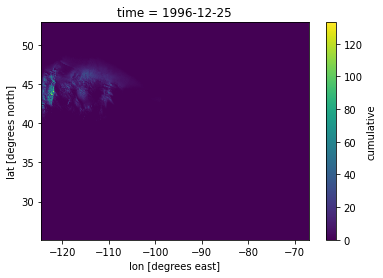

In [8]:
# basic plotting
dr_out.plot()

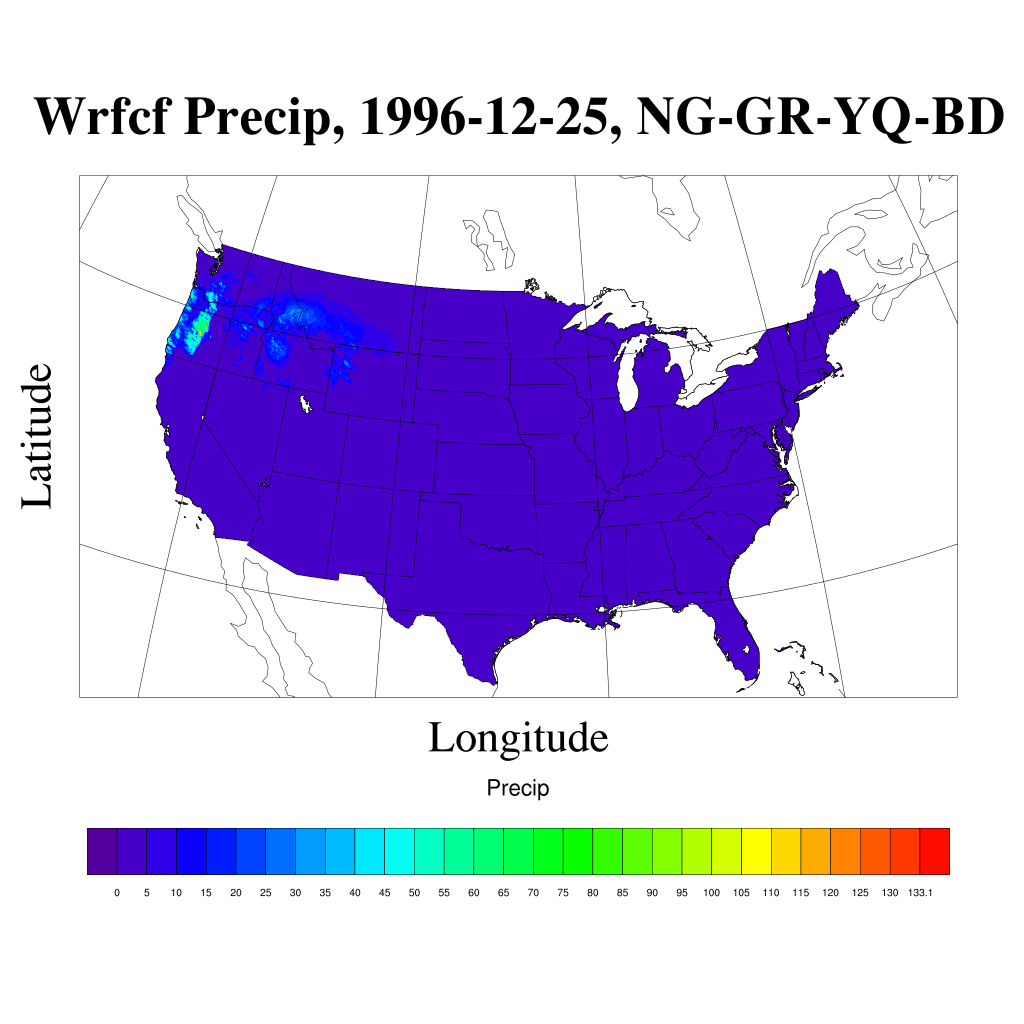

In [9]:
# extra plotting

# workstation
wks_type = "png"
wks = Ngl.open_wks(wks_type,"precip_regrid_1996_12-25_NG-GR-YQ-BD")

# clearing nans
arr = dr_out[0].data.astype('float')
arr[arr == 0.0] = 0
import numpy.ma as ma
m_out = ma.masked_invalid(arr)

# defining variables
temp = m_out
tlo = ds["lon"].data.flatten()
tla = ds["lat"].data.flatten()
tmax_lon  =  dr_out[0]['lon'].data.flatten()
tmax_lat  =  dr_out[0]['lat'].data.flatten()
tmax_nlon =  len(tmax_lon)
tmax_nlat =  len(tmax_lat)

# XY of overlay plot
resources = Ngl.Resources()

# fill missing values as needed
if hasattr(temp,"_FillValue"):
    resources.sfMissingValueV = temp[0]._FillValue

resources.sfXCStartV = min(tmax_lon)
resources.sfXCEndV   = max(tmax_lon)
resources.sfYCStartV = min(tmax_lat)
resources.sfYCEndV   = max(tmax_lat)

# cmap
resources.cnLevelSelectionMode = "ManualLevels"
resources.cnMinLevelValF       = 0
resources.cnMaxLevelValF       = max(dr_out.data.flatten())
resources.cnLevelSpacingF      = 5

# plot styling
resources.mpFillOn              = True
resources.mpFillAreaSpecifiers  = ["Water","Land","USStatesWater"]
resources.mpSpecifiedFillColors = [0,0,0]
resources.mpAreaMaskingOn       = True            
resources.mpMaskAreaSpecifiers  = "USStatesLand"
resources.cnFillDrawOrder       = "Predraw" 
Ngl.set_values(wks,resources)
resources.tiXAxisString = "~F25~Longitude"
resources.tiYAxisString = "~F25~Latitude"
resources.cnFillOn              = True    
resources.cnLineLabelsOn        = False  
resources.cnInfoLabelOn         = False  
resources.nglSpreadColorEnd     = -2
resources.mpProjection = "LambertEqualArea" 
resources.mpCenterLonF = (tmax_lon[tmax_nlon-1] + tmax_lon[0])/2
resources.mpCenterLatF = (tmax_lat[tmax_nlat-1] + tmax_lat[0])/2
resources.mpLimitMode = "LatLon"
resources.mpMinLonF   = min(tlo)
resources.mpMaxLonF   = max(tlo)
resources.mpMinLatF   = min(tla)
resources.mpMaxLatF   = max(tla)
resources.mpPerimOn   = True
resources.cnLinesOn   = False
resources.mpOutlineBoundarySets = "GeophysicalAndUSStates"
resources.pmTickMarkDisplayMode = "Never"
resources.tiMainString = "~F26~Wrfcf Precip, 1996-12-25, NG-GR-YQ-BD"
resources.lbOrientation  = "Horizontal"
resources.lbTitleString  = "Precip"   

# plot
map = Ngl.contour_map(wks,temp,resources)

# clean up
del map
del resources
Ngl.end()

# display plot (needs further cleaning later)
display.Image("./precip_regrid_1996_12-25_NG-GR-YQ-BD.png")